**Author:** [Riccardo Guidotti](http://kdd.isti.cnr.it/people/riccardo-guidotti)  
**Python version:**  3.x

In [14]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re #importo 
from datetime import date #importo

from collections import Counter
from collections import defaultdict

# Data Preparation

In [11]:
class_name = 'Occupancy'
df = pd.read_csv('datatrainingcopy.csv', skipinitialspace=True, na_values='?', keep_default_na=True, parse_dates=True)
# aggiungiamo dopo la key: index_col='date', parse_dates=True

columns2remove = ['Number'] #eliminiamo perchè non ci servono
df.drop(columns2remove, inplace=True, axis=1)
df.head()

,date,Temperature,Humidity,Light,CO2,HumidityRatio,Occupancy
0,2/4/15 17:51,23.18,27.2720,426.0,721.25,0.004793,1
1,2/4/15 17:51,23.15,27.2675,429.5,714.00,0.004783,1
2,2/4/15 17:53,23.15,27.2450,426.0,713.50,0.004779,1
3,2/4/15 17:54,23.15,27.2000,426.0,708.25,0.004772,1
4,2/4/15 17:55,23.10,27.2000,426.0,704.50,0.004757,1


In [12]:
def prepare_dataset(df, class_name):
    df = remove_missing_values(df)
    
    
    numeric_columns = get_numeric_columns(df)
    rdf = df.copy(deep=True)
    df, feature_names, class_values = one_hot_encoding(df, class_name)
    real_feature_names = get_real_feature_names(rdf, numeric_columns, class_name)
    rdf = rdf[real_feature_names + (class_values if isinstance(class_name, list) else [class_name])]
    features_map = get_features_map(feature_names, real_feature_names)

    return df, feature_names, class_values, numeric_columns, rdf, real_feature_names, features_map

def remove_missing_values(df):
    for column_name, nbr_missing in df.isna().sum().to_dict().items():
        if nbr_missing > 0:
            if column_name in df._get_numeric_data().columns:
                mean = df[column_name].mean()
                df[column_name].fillna(mean, inplace=True)
            else:
                mode = df[column_name].mode().values[0]
                df[column_name].fillna(mode, inplace=True)
    return df

def get_numeric_columns(df):
    numeric_columns = list(df._get_numeric_data().columns)
    return numeric_columns

def get_real_feature_names(rdf, numeric_columns, class_name):
    real_feature_names = [c for c in rdf.columns if c in numeric_columns and c != class_name]
    real_feature_names += [c for c in rdf.columns if c not in numeric_columns and c != class_name]
    return real_feature_names

def one_hot_encoding(df, class_name):
    dfX = pd.get_dummies(df[[c for c in df.columns if c != class_name]], prefix_sep='=')
    class_name_map = {v: k for k, v in enumerate(sorted(df[class_name].unique()))}
    dfY = df[class_name].map(class_name_map)
    df = pd.concat([dfX, dfY], axis=1, join_axes=[dfX.index])
    feature_names = list(dfX.columns)
    class_values = sorted(class_name_map)
    return df, feature_names, class_values

def get_features_map(feature_names, real_feature_names):
    features_map = defaultdict(dict)
    i = 0
    j = 0

    while i < len(feature_names) and j < len(real_feature_names):
        if feature_names[i] == real_feature_names[j]:
            features_map[j][feature_names[i]] = j
            i += 1
            j += 1
        elif feature_names[i].startswith(real_feature_names[j]):
            features_map[j][feature_names[i]] = j
            i += 1
        else:
            j += 1
    return features_map

#----------------------------------------------------------------------
#creiamo una nuova variabile che assegna valore 1 ai giorni da Lun a Ven
#0 per Sab e Dom

def convert_date(date_in_str):
    
    date_list = re.findall(r"\w+", date_in_str)
    month = date_list[0]
    dat = date_list[1]
    year = '20' + date_list[2]
    num_day = date(int(year),int(month),int(dat)).weekday()    


    # 0 è lunedi', 2 è mercoledi 
    #dobbiamo convertire 5 e 6 in 0 per definirle come weekend days (sabato e domenica )

    if num_day >= 5:
        return 0 
    else:
        return 1

In [15]:
df['Week_day'] = df.date.apply(convert_date)

In [16]:
df.head()

,date,Temperature,Humidity,Light,CO2,HumidityRatio,Occupancy,Week_day
0,2/4/15 17:51,23.18,27.2720,426.0,721.25,0.004793,1,1
1,2/4/15 17:51,23.15,27.2675,429.5,714.00,0.004783,1,1
2,2/4/15 17:53,23.15,27.2450,426.0,713.50,0.004779,1,1
3,2/4/15 17:54,23.15,27.2000,426.0,708.25,0.004772,1,1
4,2/4/15 17:55,23.10,27.2000,426.0,704.50,0.004757,1,1


In [20]:
columns2remove = ['date'] #eliminiamo perchè non ci servono
df.drop(columns2remove, inplace=True, axis=1)


KeyError: "['date'] not found in axis"

In [21]:
df.head() #abbiamo eliminato la data

,Temperature,Humidity,Light,CO2,HumidityRatio,Occupancy,Week_day
0,23.18,27.2720,426.0,721.25,0.004793,1,1
1,23.15,27.2675,429.5,714.00,0.004783,1,1
2,23.15,27.2450,426.0,713.50,0.004779,1,1
3,23.15,27.2000,426.0,708.25,0.004772,1,1
4,23.10,27.2000,426.0,704.50,0.004757,1,1


In [4]:
import sys
sys.path.append('./') #non rannare

In [5]:
from data_preparation import prepare_dataset #non rannare

In [22]:
res = prepare_dataset(df, class_name)
df, feature_names, class_values, numeric_columns, rdf, real_feature_names, features_map = res
df.head()

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:38: FutureWarning: The join_axes-keyword is deprecated. Use .reindex or .reindex_like on the result to achieve the same functionality.


,Temperature,Humidity,Light,CO2,HumidityRatio,Week_day,Occupancy
0,23.18,27.2720,426.0,721.25,0.004793,1,1
1,23.15,27.2675,429.5,714.00,0.004783,1,1
2,23.15,27.2450,426.0,713.50,0.004779,1,1
3,23.15,27.2000,426.0,708.25,0.004772,1,1
4,23.10,27.2000,426.0,704.50,0.004757,1,1


# Data Partitioning

In [23]:
from sklearn.model_selection import train_test_split, cross_val_score 

from sklearn.metrics import accuracy_score, f1_score, classification_report
from sklearn.metrics import roc_curve, auc, roc_auc_score

In [24]:
attributes = [col for col in df.columns if col != class_name]
X = df[attributes].values
y = df[class_name]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=100, stratify=y)

In [26]:
X_train.shape #quante righe e colone ha la nostra matrice

(5700, 6)

# Classification

In [27]:
from sklearn.tree import DecisionTreeClassifier

In [28]:
clf = DecisionTreeClassifier(min_samples_leaf=3, random_state=42) #non rannare in datatest
clf.fit(X_train, y_train) #non rannare per test

y_pred = clf.predict(X_test) #fai nuova cell e ranna solo questa riga

print('Accuracy %s' % accuracy_score(y_test, y_pred))
print('F1-score %s' % f1_score(y_test, y_pred, average=None))
print(classification_report(y_test, y_pred))

Accuracy 0.9914040114613181
F1-score [0.99456381 0.97947214]
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      1924
           1       0.99      0.97      0.98       519

    accuracy                           0.99      2443
   macro avg       0.99      0.98      0.99      2443
weighted avg       0.99      0.99      0.99      2443



# Variance Threshold

In [29]:
from sklearn.feature_selection import VarianceThreshold

In [32]:
sel = VarianceThreshold(threshold=(.8 * (1 - .8)))
X_train_sel = sel.fit_transform(X_train)

X_train_sel.shape



(5700, 5)

In [35]:
X_train_sel[0:10] #guarda la teoria

array([[2.00666667e+01, 2.42900000e+01, 0.00000000e+00, 4.41000000e+02,
        0.00000000e+00],
       [1.97000000e+01, 1.93900000e+01, 0.00000000e+00, 4.44000000e+02,
        0.00000000e+00],
       [1.95000000e+01, 2.76500000e+01, 0.00000000e+00, 4.54000000e+02,
        0.00000000e+00],
       [2.12300000e+01, 2.56333333e+01, 0.00000000e+00, 4.71666667e+02,
        1.00000000e+00],
       [2.20666667e+01, 2.71666667e+01, 0.00000000e+00, 5.66333333e+02,
        1.00000000e+00],
       [1.97300000e+01, 1.93900000e+01, 0.00000000e+00, 4.44000000e+02,
        0.00000000e+00],
       [2.22900000e+01, 2.61750000e+01, 4.42500000e+02, 1.06475000e+03,
        1.00000000e+00],
       [1.94633333e+01, 2.72600000e+01, 0.00000000e+00, 4.28000000e+02,
        0.00000000e+00],
       [2.02900000e+01, 3.29000000e+01, 0.00000000e+00, 4.52000000e+02,
        1.00000000e+00],
       [2.16000000e+01, 2.00000000e+01, 6.70000000e+01, 7.58000000e+02,
        1.00000000e+00]])

In [36]:
X_test_sel = sel.transform(X_test)

clf = DecisionTreeClassifier(min_samples_leaf=3, random_state=42)
clf.fit(X_train_sel, y_train)

y_pred = clf.predict(X_test_sel)

print('Accuracy %s' % accuracy_score(y_test, y_pred))
print('F1-score %s' % f1_score(y_test, y_pred, average=None))
print(classification_report(y_test, y_pred))

Accuracy 0.9909946786737618
F1-score [0.99430642 0.97847358]
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      1924
           1       0.99      0.96      0.98       519

    accuracy                           0.99      2443
   macro avg       0.99      0.98      0.99      2443
weighted avg       0.99      0.99      0.99      2443



# Univariate Feature Selection

In [39]:
from sklearn.feature_selection import SelectKBest

In [48]:
sel = SelectKBest(k='all') #cambiato con k=10
#perche gli stiamo dicendo di scegliere la miglior feature tra le feature
#non ne avevamo 10, ma 6 quindi dobbiamo scrivere all
X_train_sel = sel.fit_transform(X_train, y_train)

X_train_sel.shape

(5700, 6)

In [49]:
X_test_sel = sel.transform(X_test)

clf = DecisionTreeClassifier(min_samples_leaf=3, random_state=42)
clf.fit(X_train_sel, y_train)

y_pred = clf.predict(X_test_sel)

print('Accuracy %s' % accuracy_score(y_test, y_pred))
print('F1-score %s' % f1_score(y_test, y_pred, average=None))
print(classification_report(y_test, y_pred))

Accuracy 0.9914040114613181
F1-score [0.99456381 0.97947214]
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      1924
           1       0.99      0.97      0.98       519

    accuracy                           0.99      2443
   macro avg       0.99      0.98      0.99      2443
weighted avg       0.99      0.99      0.99      2443



# Recursive Feature Elimination

In [50]:
from sklearn.feature_selection import SelectFromModel

In [51]:
sel = SelectFromModel(DecisionTreeClassifier())
X_train_sel = sel.fit_transform(X_train, y_train)
X_train_sel.shape

(5700, 1)

In [52]:
X_test_sel = sel.transform(X_test)

clf = DecisionTreeClassifier(min_samples_leaf=3, random_state=42)
clf.fit(X_train_sel, y_train)

y_pred = clf.predict(X_test_sel)

print('Accuracy %s' % accuracy_score(y_test, y_pred))
print('F1-score %s' % f1_score(y_test, y_pred, average=None))
print(classification_report(y_test, y_pred))

Accuracy 0.9836266884977487
F1-score [0.98959417 0.96161228]
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      1924
           1       0.96      0.97      0.96       519

    accuracy                           0.98      2443
   macro avg       0.97      0.98      0.98      2443
weighted avg       0.98      0.98      0.98      2443



# Principal Component Analysis

In [53]:
from sklearn.decomposition import PCA

The goal of PCA is to find a new set of dimensions (attributes or features) that better captures the variability of the data.

In [54]:
pca = PCA(n_components=2)
pca.fit(X_train)
X_train_pca = pca.transform(X_train)

In [55]:
X_train_pca.shape

(5700, 2)

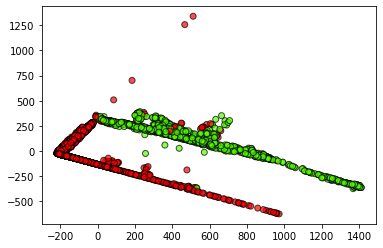

In [56]:
plt.scatter(X_train_pca[:, 0], X_train_pca[:, 1], c=y_train, cmap=plt.cm.prism, edgecolor='k', alpha=0.7)
plt.show()

In [57]:
X_test_pca = pca.transform(X_test)

clf = DecisionTreeClassifier(min_samples_leaf=3, random_state=42)
clf.fit(X_train_pca, y_train)

y_pred = clf.predict(X_test_pca)

print('Accuracy %s' % accuracy_score(y_test, y_pred))
print('F1-score %s' % f1_score(y_test, y_pred, average=None))
print(classification_report(y_test, y_pred))

Accuracy 0.9836266884977487
F1-score [0.98961039 0.96138996]
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      1924
           1       0.96      0.96      0.96       519

    accuracy                           0.98      2443
   macro avg       0.98      0.97      0.98      2443
weighted avg       0.98      0.98      0.98      2443



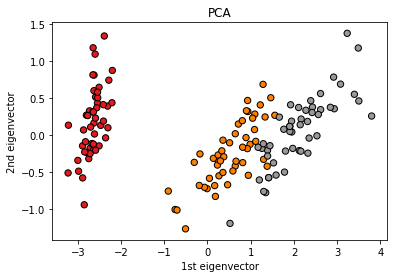

In [59]:
from sklearn import datasets

iris = datasets.load_iris()
X_pca = PCA(n_components=2).fit_transform(iris.data)
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=iris.target, cmap=plt.cm.Set1, edgecolor='k', s=40)
plt.title("PCA")
plt.xlabel("1st eigenvector")
plt.ylabel("2nd eigenvector")
plt.show()

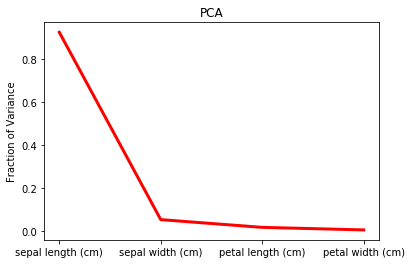

In [60]:
plt.plot(PCA(n_components=4).fit(iris.data).explained_variance_ratio_, lw=3, color='r', ms=2)
plt.title("PCA")
plt.ylabel("Fraction of Variance")
plt.xticks(range(4), iris.feature_names)
plt.show()